In [1]:
import tensorflow as tf
import tensorflow.keras as tk
import numpy as np
import matplotlib.pyplot as pplt
from tqdm import tqdm
import os

import cv2

from random import shuffle

In [2]:
TRAIN_DIR='/home/ravisankar/Desktop/DesktopFiles/python_ML/dogs-vs-cats/train'
TEST_DIR='/home/ravisankar/Desktop/DesktopFiles/python_ML/dogs-vs-cats/test'
IMG_SIZE=50
LR= 1e-3

MODEL_NAME='dogsvscats-{}-{}.model'.format(LR,'2conv-basic')

In [3]:
#cat,dog
def label_img(img):
  #dog.93.png
  #-3 .-2.-1
  word_label=img.split('.')[-3]
  if word_label == 'cat': return [1,0]
  elif word_label == 'dog' :return [0,1]

In [4]:
def create_train_data():
  train_data=[]
  for img in tqdm(os.listdir(TRAIN_DIR)):
    label=label_img(img)
    path = os.path.join(TRAIN_DIR,img)
    img=cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
    
    train_data.append([np.array(img),np.array(label)])
  shuffle(train_data)
  np.save('train_data.npy',train_data)
  return train_data

In [5]:
def process_test_data():
  test_data=[]
  for img in tqdm(os.listdir(TEST_DIR)):
    #label=label_img(img)
    path = os.path.join(TEST_DIR,img)
    img_num=img.split('.')[0]
    img=cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
    
    test_data.append([np.array(img),img_num])
  #shuffle(train_data)
  np.save('test_data.npy',test_data)
  return test_data

In [6]:
#training_data = create_train_data()
training_data=np.load('train_data.npy')




In [33]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression



tf.reset_default_graph()
convnet = input_data(shape=[None,IMG_SIZE,IMG_SIZE,1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)


convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet,tensorboard_dir='log')
#model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
#    snapshot_step=500, show_metric=True, run_id='mnist')

In [14]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/ravisankar/Desktop/DesktopFiles/python_ML/dogs-vs-cats/dogsvscats-0.001-2conv-basic.model
model loaded!


In [9]:
train=training_data[:-500]
test=training_data[-500:]



In [10]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y =[i[1] for i in train]


test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y= [i[1] for i in test]

In [15]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 0.40122 | time: 92.121s
| Adam | epoch: 010 | loss: 0.40122 - acc: 0.8094 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.40427 | time: 93.366s
| Adam | epoch: 010 | loss: 0.40427 - acc: 0.8082 | val_loss: 0.45805 - val_acc: 0.7980 -- iter: 24500/24500
--


In [12]:
#tensorboard --logdir=/home/ravisankar/Desktop/DesktopFiles/python_ML/dogs-vs-cats/log

In [13]:
model.save(MODEL_NAME)

INFO:tensorflow:/home/ravisankar/Desktop/DesktopFiles/python_ML/dogs-vs-cats/dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 12500/12500 [00:09<00:00, 1329.24it/s]


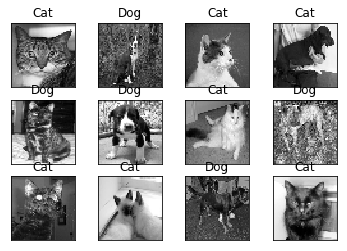

In [26]:
#if file is not created 
testing_data=process_test_data()
#if file is created
#testing_data=np.load(test_data.npy)
#dog[0,1]
   #[0,1]
#cat[1,0]
   
figure=pplt.figure()
for num,data in enumerate(testing_data[:12]):
    img_num=data[1]
    img_data=data[0]
    
    y=figure.add_subplot(3,4,num+1)
    original=img_data
    data=img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out=model.predict([data])[0]
    if np.argmax(model_out)==1:
        str_label='Dog'
    else:
        str_label='Cat'
    y.imshow(original,cmap='gray')
    pplt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
    
pplt.show()    

In [29]:
with open('submission-catvsdog-kaggle.csv','w') as f:
    f.write('id,dogness score,dog or cat\n')

In [32]:
with open('submission-catvsdog-kaggle.csv','w') as f:
    for data in tqdm(testing_data):
        img_num=data[1]
        img_data=data[0]
        original=img_data
        data=img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out=model.predict([data])[0]
        if model_out[1]>=0.50:
            str1='Dog'
            f.write('{},{},{}\n'.format(img_num,model_out[1],str1))
        else:
            str1='Cat'
            f.write('{},{},{}\n'.format(img_num,model_out[1],str1))

100%|██████████| 12500/12500 [00:19<00:00, 657.88it/s]
